In [1]:

import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

In [4]:

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [5]:
class NormalizedActions(gym.ActionWrapper):

    def _action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        
        action = low_bound + (action + 1.0) * 0.5 * (upper_bound - low_bound)
        action = np.clip(action, low_bound, upper_bound)
        
        return action

    def _reverse_action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        
        action = 2 * (action - low_bound) / (upper_bound - low_bound) - 1
        action = np.clip(action, low_bound, upper_bound)
        
        return actions

In [6]:
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)
    
#https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py

In [7]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

In [8]:
class ValueNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
    

class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(PolicyNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, num_actions)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = F.tanh(self.linear3(x))
        return x
    
    def get_action(self, state):
        state  = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = self.forward(state)
        return action.detach().cpu().numpy()[0, 0]

In [12]:
def ddpg_update(batch_size, 
           gamma = 0.99,
           min_value=-np.inf,
           max_value=np.inf,
           soft_tau=1e-2):
    
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    policy_loss = value_net(state, policy_net(state))
    policy_loss = -policy_loss.mean()

    next_action    = target_policy_net(next_state)
    target_value   = target_value_net(next_state, next_action.detach())
    expected_value = reward + (1.0 - done) * gamma * target_value
    expected_value = torch.clamp(expected_value, min_value, max_value)

    value = value_net(state, action)
    value_loss = value_criterion(value, expected_value.detach())


    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()

    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

    for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )
    return value_loss.item(), policy_loss.item()

In [10]:
env = NormalizedActions(gym.make("Pendulum-v0"))
ou_noise = OUNoise(env.action_space)

state_dim  = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
hidden_dim = 256

value_net  = ValueNetwork(state_dim, action_dim, hidden_dim).to(device)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

target_value_net  = ValueNetwork(state_dim, action_dim, hidden_dim).to(device)
target_policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
    target_param.data.copy_(param.data)
    
    
value_lr  = 1e-3
policy_lr = 1e-4

value_optimizer  = optim.Adam(value_net.parameters(),  lr=value_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)

value_criterion = nn.MSELoss()

replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

In [11]:

max_frames  = 12000
max_steps   = 500
frame_idx   = 0
rewards     = []
batch_size  = 128

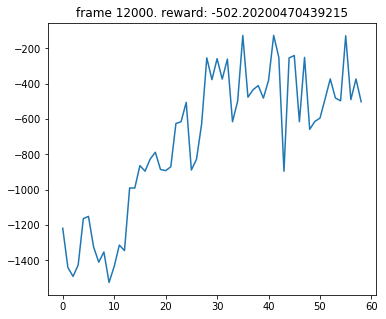

In [13]:
v_loss, p_loss = [], []

while frame_idx < max_frames:
    state = env.reset()
    ou_noise.reset()
    episode_reward = 0
    
    for step in range(max_steps):
        action = policy_net.get_action(state)
        action = ou_noise.get_action(action, step)
        next_state, reward, done, _ = env.step(action)
        
        replay_buffer.push(state, action, reward, next_state, done)
        if len(replay_buffer) > batch_size:
            value_loss, policy_loss = ddpg_update(batch_size)
            v_loss.append(value_loss)
            p_loss.append(policy_loss)
        
        state = next_state
        episode_reward += reward
        frame_idx += 1
        
        if frame_idx % max(1000, max_steps + 1) == 0:
            plot(frame_idx, rewards)
        
        if done:
            break
    
    rewards.append(episode_reward)

Text(0.5,1,'Policy loss')

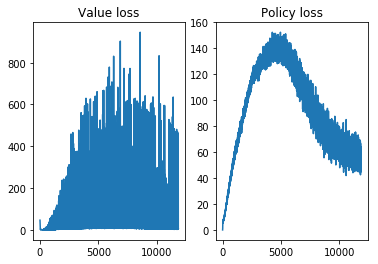

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(range(len(v_loss)), v_loss)
ax1.set_title('Value loss')
ax2.plot(range(len(p_loss)), p_loss)
ax2.set_title('Policy loss')